### Generate figures that tell a story about feature value entropy (confidence)

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

warnings.filterwarnings('ignore')

### Load units with highest correlation to feature entropy

In [11]:
correlations = pd.read_pickle("/data/patrick_res/glm_2/feat_entropy_correlations.pickle")
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(sessions)
correlations = pd.merge(correlations, positions, on=["PseudoUnitID", "session", "UnitID"])
correlations["r_mag"] = correlations.r_value.abs()

In [12]:
correlations.sort_values(by="r_mag", ascending=False)[:10][["PseudoUnitID", "r_value", "structure_level2"]]

PseudoUnitID   r_value                structure_level2
656    2018071202 -0.572822              basal_ganglia (BG)
406    2018092414  0.569066  inferior_temporal_cortex (ITC)
562    2018092115  0.544076  inferior_temporal_cortex (ITC)
50     2018092006  0.511619  inferior_temporal_cortex (ITC)
537    2018101008 -0.504193              basal_ganglia (BG)
597    2018092514  0.487308  inferior_temporal_cortex (ITC)
352    2018080227  0.466052    orbital_frontal_cortex (OFC)
309    2018100109  0.465816  inferior_temporal_cortex (ITC)
712    2018092808  0.451946  inferior_temporal_cortex (ITC)
554    2018092107  0.443856  inferior_temporal_cortex (ITC)

In [13]:
SMOOTH = 1
num_bins = 10
mode = "FiringRate"

def visualize_correlations(row, interesting_feats=[], by_dims=False):
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins, quantize_bins=True)
    beh = behavioral_utils.calc_feature_probs(beh)
    beh = behavioral_utils.calc_feature_value_entropy(beh, num_bins, quantize_bins=True)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    merged = pd.merge(agg, beh, on="TrialNumber")
    merged = spike_utils.zscore_frs(merged, group_cols=["UnitID", "BlockNumber"], mode="FiringRate")

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    ax = axs[0, 0]
    visualization_utils.plot_mean_sterrs_by_bin(merged, mode, "MaxValueBin", ax=ax, label=row.PseudoUnitID, num_bins=num_bins)
    # for dim in POSSIBLE_FEATURES:
    #     features = POSSIBLE_FEATURES[dim]
    #     sub_merged = merged[merged.CurrentRule.isin(features)]
    #     visualization_utils.plot_mean_sterrs_by_bin(sub_merged, mode, "MaxValueBin", ax, label=dim, num_bins=num_bins)
    for feat in interesting_feats:
        sub_merged = merged[merged.CurrentRule == feat]
        visualization_utils.plot_mean_sterrs_by_bin(sub_merged, mode, "MaxValueBin", ax, label=feat, num_bins=num_bins)
    ax.legend()
    ax.set_xlabel("Max Value Bin")
    ax.set_ylabel("Mean firing in inter-trial")
    ax.set_title(f"{row.structure_level2}: {row.PseudoUnitID}")

    # ax = axs[0, 1]
    # mean_sub = spike_utils.mean_sub_frs(merged, group_cols=["UnitID", "BlockNumber"], mode=mode)
    # filt = mean_sub[mean_sub.MaxValue > 0.3]
    # # visualization_utils.plot_bars_by_cat(filt, f"MeanSub{mode}", "MaxFeat", ax, order=FEATURES)
    # visualization_utils.plot_bars_by_cat(filt, mode, "MaxFeat", ax, order=FEATURES)
    # # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    # ax.set_ylabel("Mean firing in inter-trial")
    # ax.set_title("Firing by max valued feat")

    ax = axs[0, 1]
    visualization_utils.plot_mean_sterrs_by_bin(merged, mode, "FeatEntropyBin", ax, row.PseudoUnitID, num_bins)
    # for dim in POSSIBLE_FEATURES:
    #     features = POSSIBLE_FEATURES[dim]
    #     sub_merged = merged[merged.CurrentRule.isin(features)]
    #     visualization_utils.plot_mean_sterrs_by_bin(sub_merged, mode, "FeatEntropyBin", ax, label=dim, num_bins=num_bins)
    for feat in interesting_feats:
        sub_merged = merged[merged.CurrentRule == feat]
        visualization_utils.plot_mean_sterrs_by_bin(sub_merged, mode, "FeatEntropyBin", ax, label=feat, num_bins=num_bins)
    if by_dims: 
        for dim in FEATURE_DIMS:
            feats = POSSIBLE_FEATURES[dim]
            sub_merged = merged[merged.CurrentRule.isin(feats)]
            visualization_utils.plot_mean_sterrs_by_bin(sub_merged, mode, "FeatEntropyBin", ax, label=dim, num_bins=num_bins)

    ax.legend()
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_xlabel("Entropy Bin")
    ax.set_ylabel("Mean firing in inter-trial")
    ax.set_title(f"{row.structure_level2}: {row.PseudoUnitID}")

    ax = axs[0, 2]
    # res_df = row.to_frame().T
    # rename_map = {f"{feat}Value_coef": feat for feat in FEATURES}
    # res_df = res_df.rename(columns=rename_map)
    # melted = pd.melt(res_df, id_vars=["PseudoUnitID", "score"], value_vars=FEATURES, var_name="feature", value_name="coef")
    # visualization_utils.plot_bars_by_cat(melted, "coef", "feature", ax, order=FEATURES)
    # # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    # ax.set_ylabel("Feature value weights")
    # ax.set_title(f"GLM Model R^2: {row.score}")
    fig.tight_layout()


    ax = axs[1, 0]
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged["MaxValue"], merged[mode])
    ax.scatter(merged["MaxValue"], merged[mode], alpha=0.3, color="black")
    ax.plot(merged["MaxValue"], merged["MaxValue"] * slope + intercept)
    ax.set_title(f"Cor w Max Value: r: {r_value:.3f}, p: {p_value:.3E}")
    ax.set_xlabel("Max Value")
    ax.set_ylabel(f"Mean {mode} in inter-trial")

    # ax = axs[1, 2]
    # num_blocks = beh.groupby("CurrentRule").BlockNumber.nunique().reset_index()
    # visualization_utils.plot_bars_by_cat(num_blocks, "BlockNumber", "CurrentRule", ax, order=FEATURES)
    # # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    # ax.set_ylabel(f"Mean {mode} in inter-trial")
    # ax.set_title("Number of blocks in session per rule")
    # fig.tight_layout()

    ax = axs[1, 1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(merged["FeatEntropy"], merged[mode])
    ax.scatter(merged["FeatEntropy"], merged[mode], alpha=0.15, color="black")
    if by_dims: 
        for dim in FEATURE_DIMS:
            feats = POSSIBLE_FEATURES[dim]
            sub_merged = merged[merged.CurrentRule.isin(feats)]
            ax.scatter(sub_merged["FeatEntropy"], sub_merged[mode], alpha=0.15, label=dim)
    ax.plot(merged["FeatEntropy"], merged["FeatEntropy"] * slope + intercept)
    ax.set_title(f"Cor w Entropy: r: {r_value:.3f}, p: {p_value:.3E}")
    ax.set_xlabel("Entropy")
    ax.set_ylabel(f"Mean {mode} in inter-trial")

    ax = axs[1, 2]
    full_merged = pd.merge(frs, beh, on="TrialNumber")
    sns.lineplot(full_merged, x="TimeBins", y="FiringRate", hue="FeatEntropyBin", ax=ax)

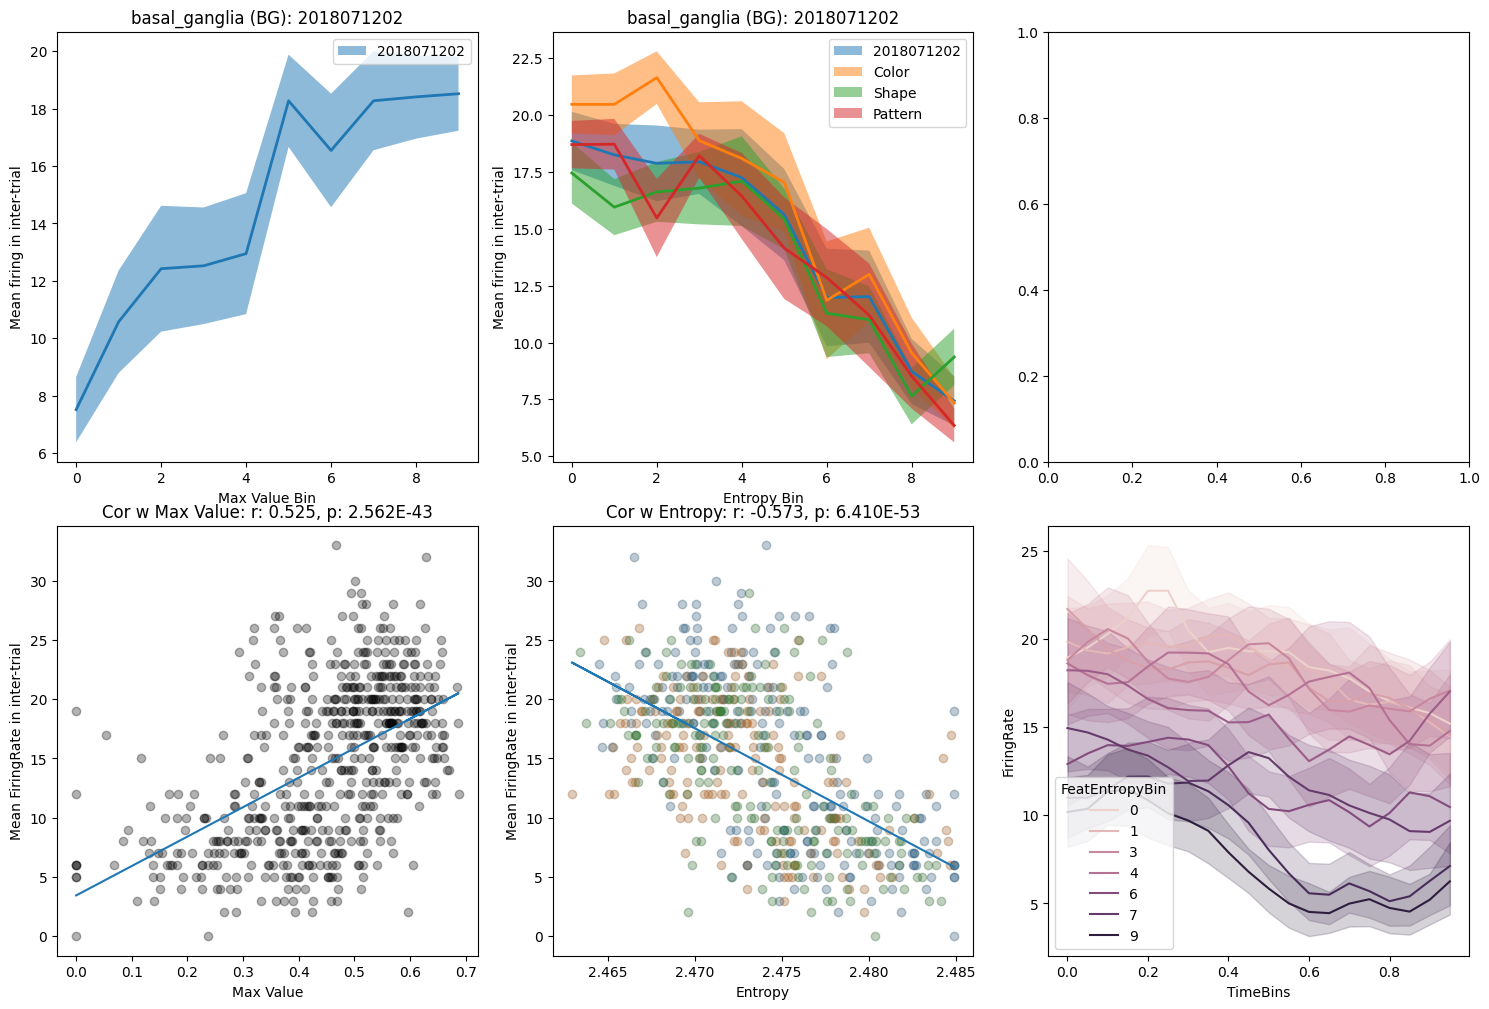

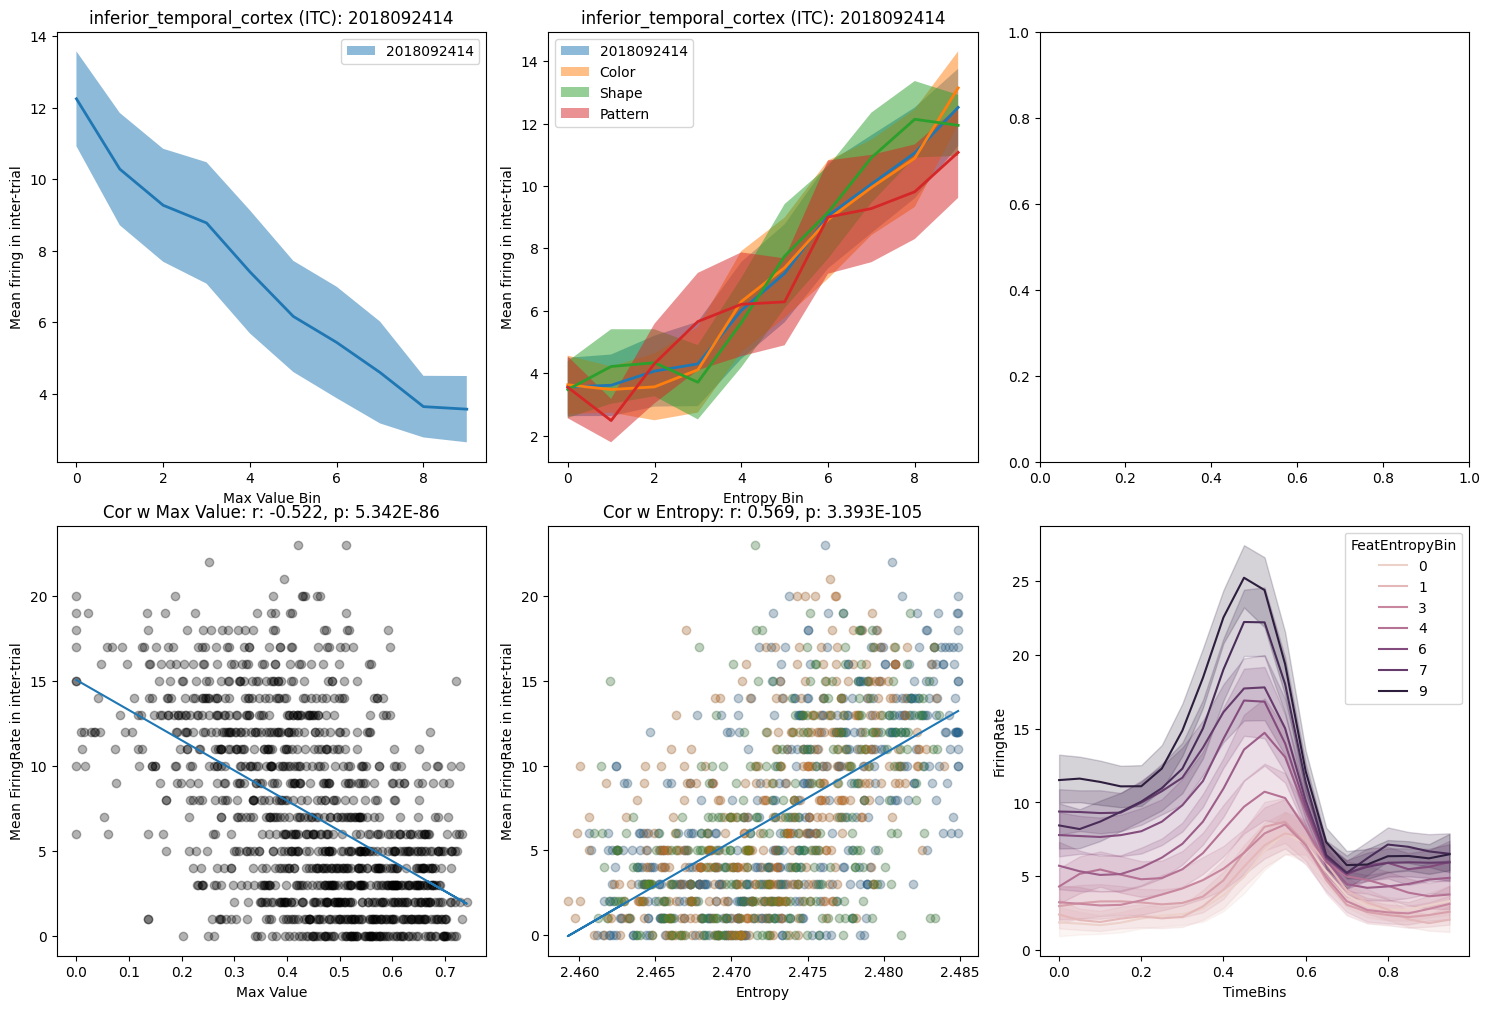

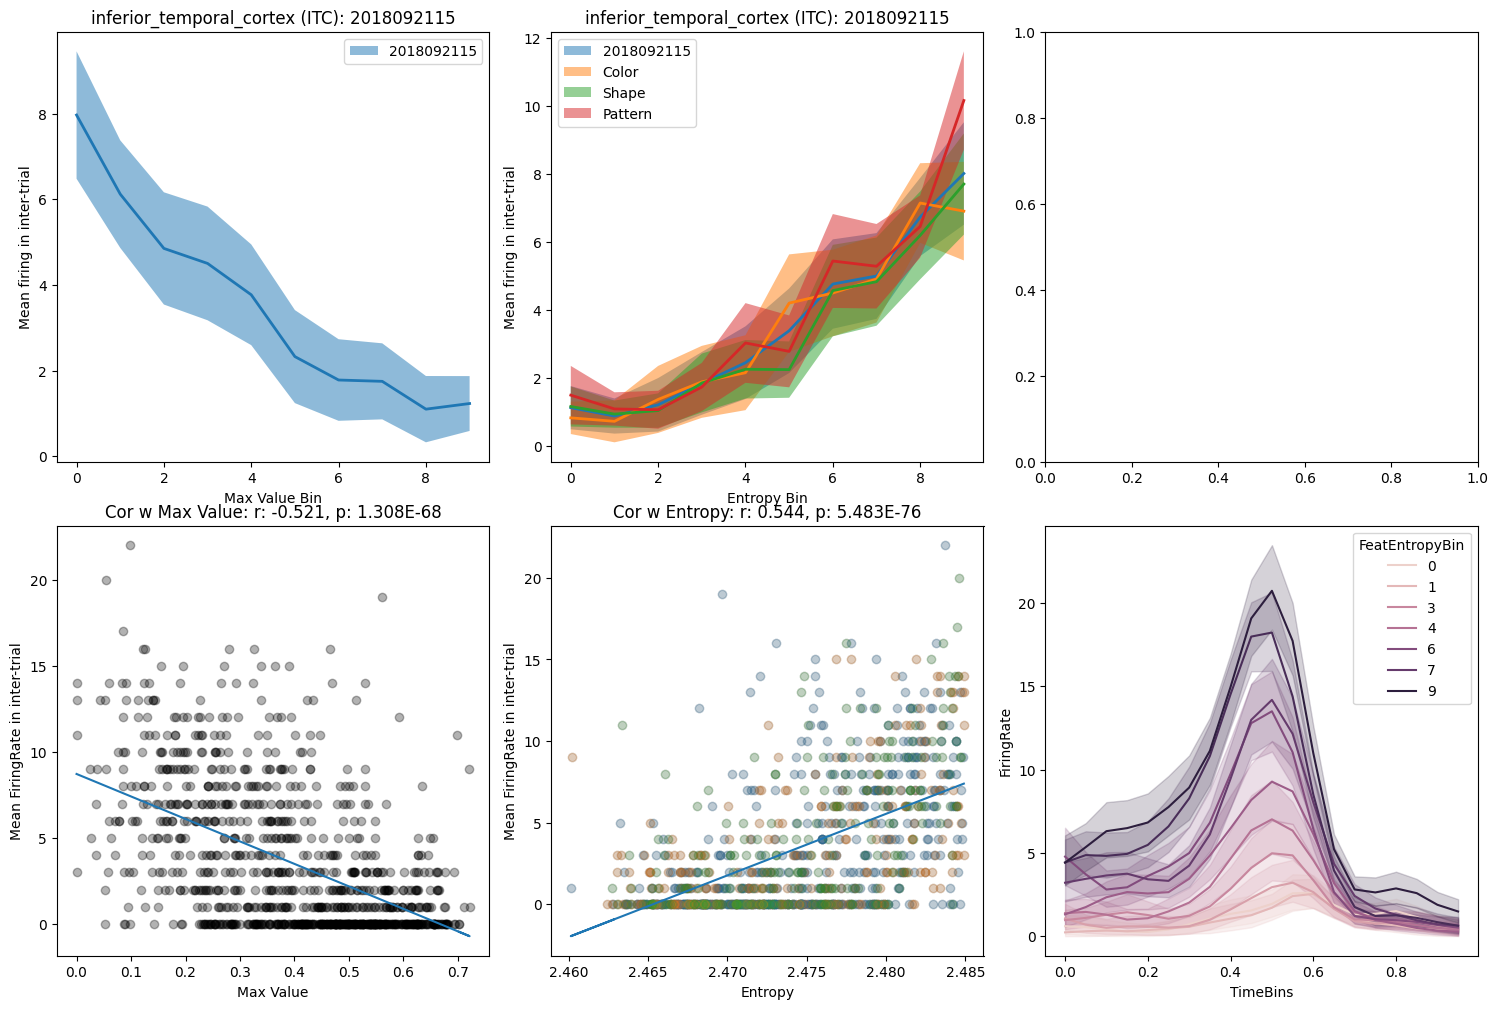

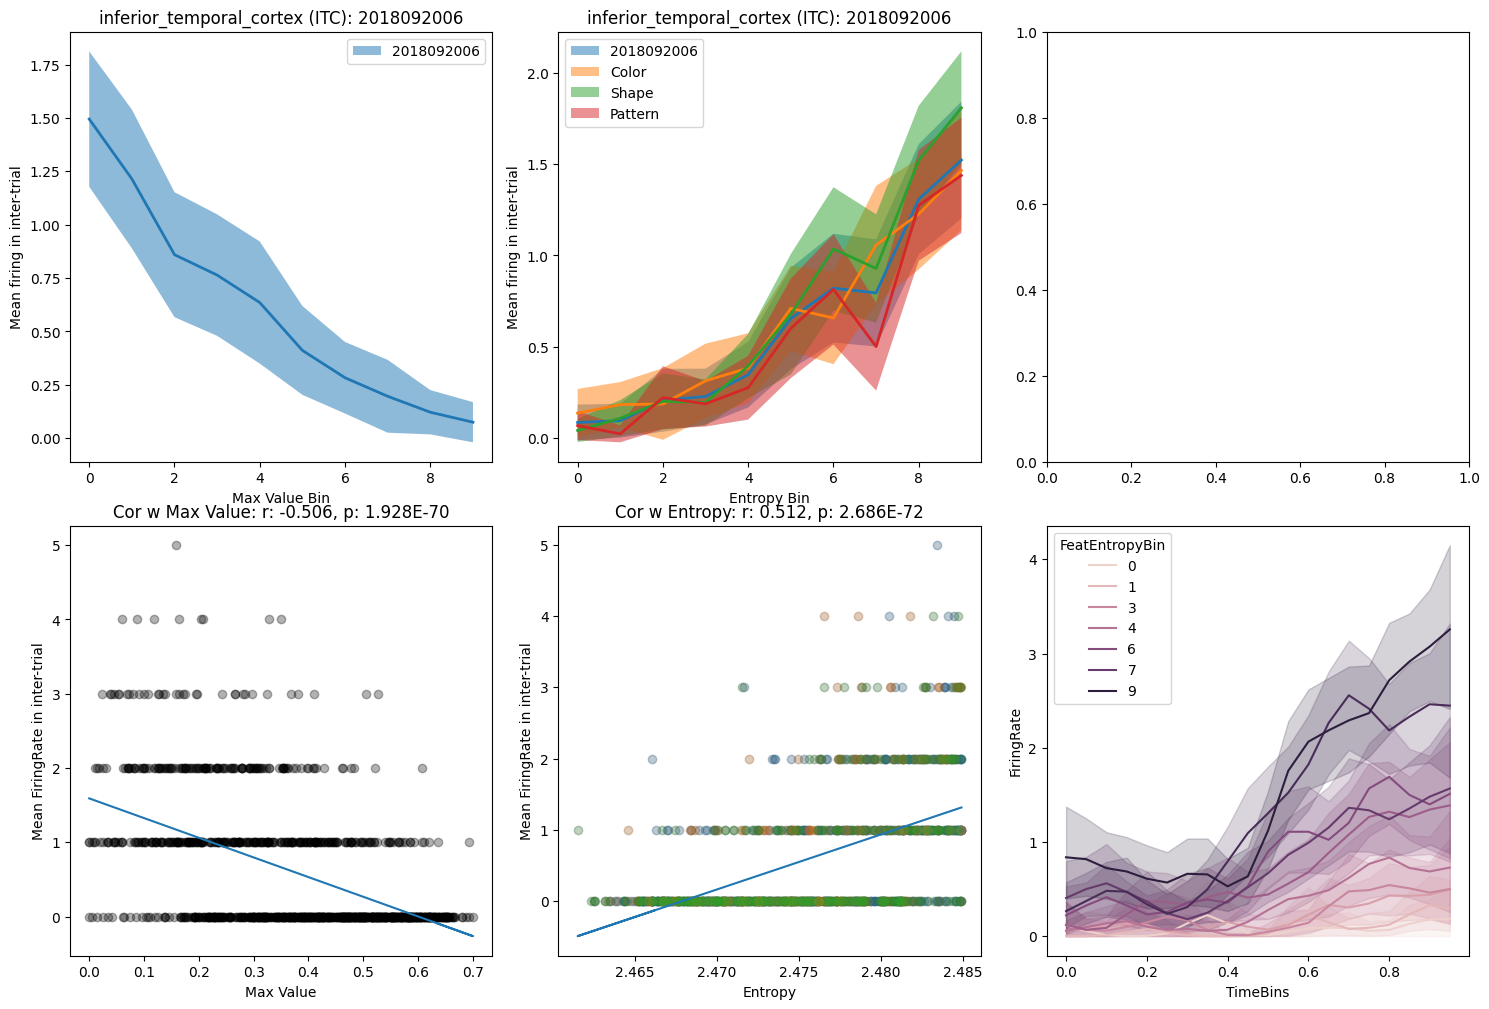

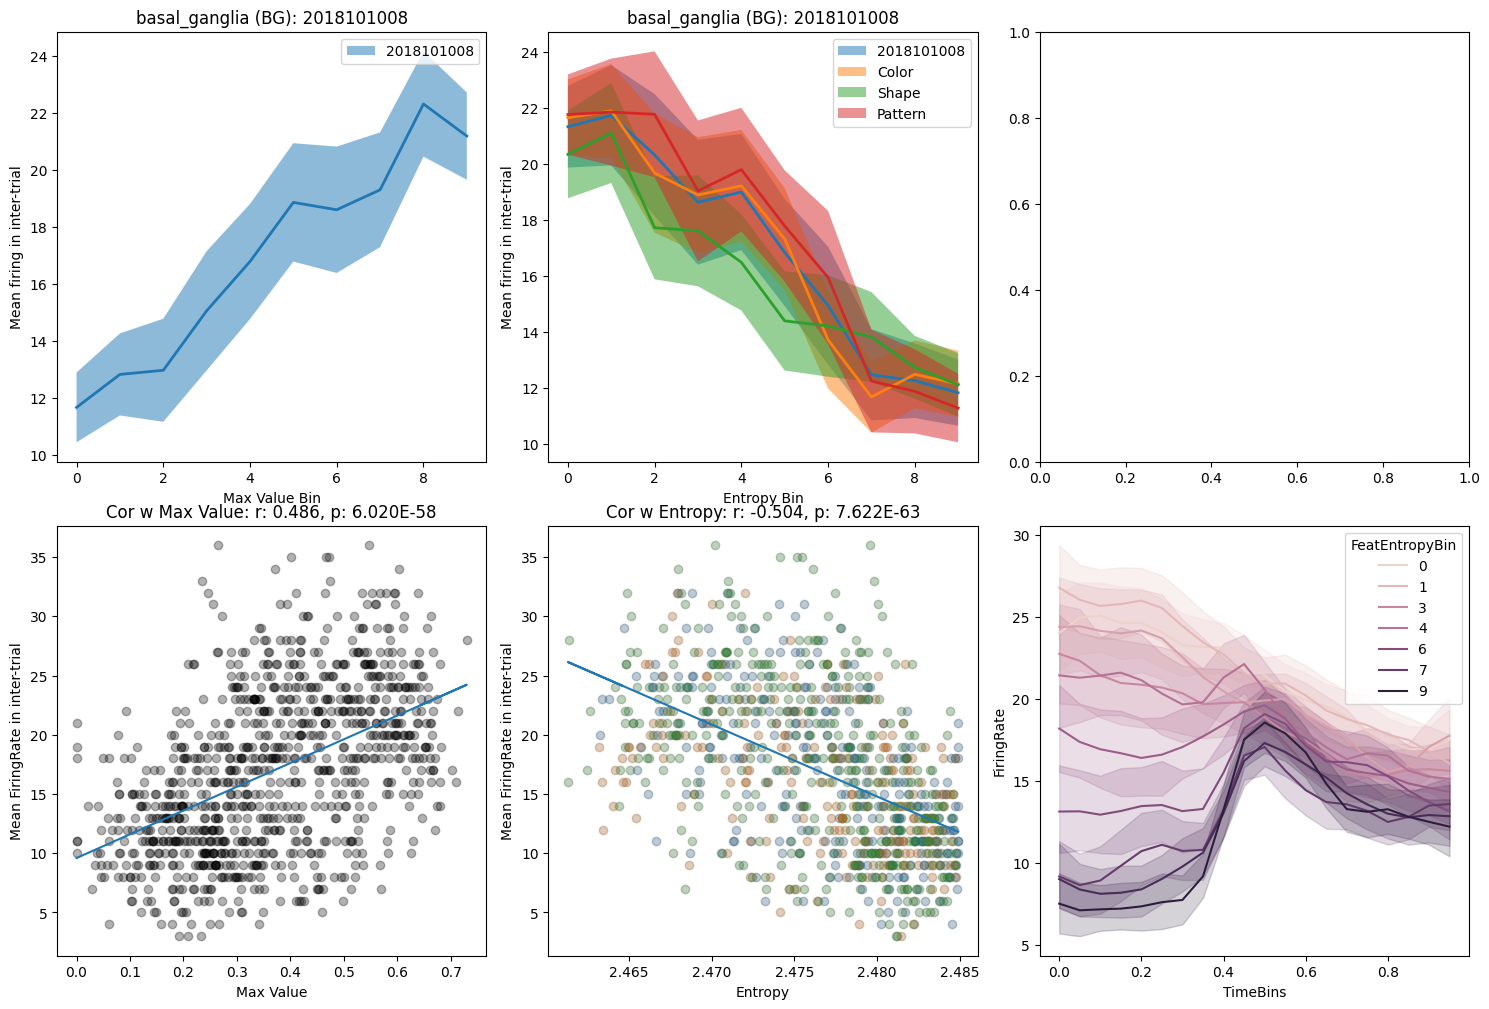

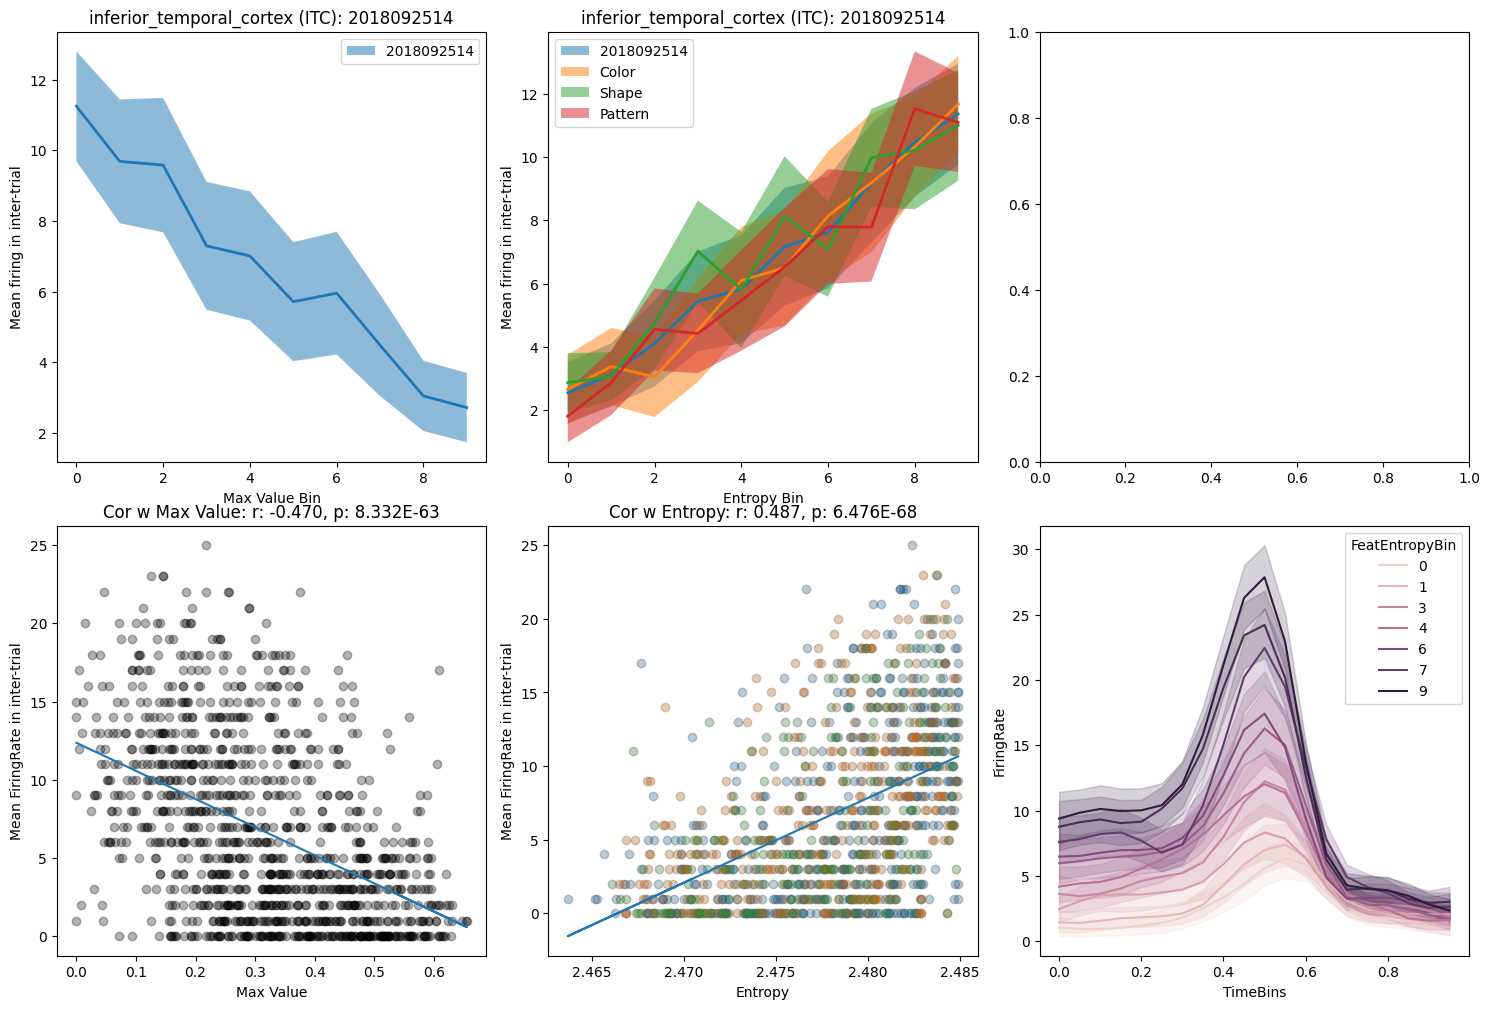

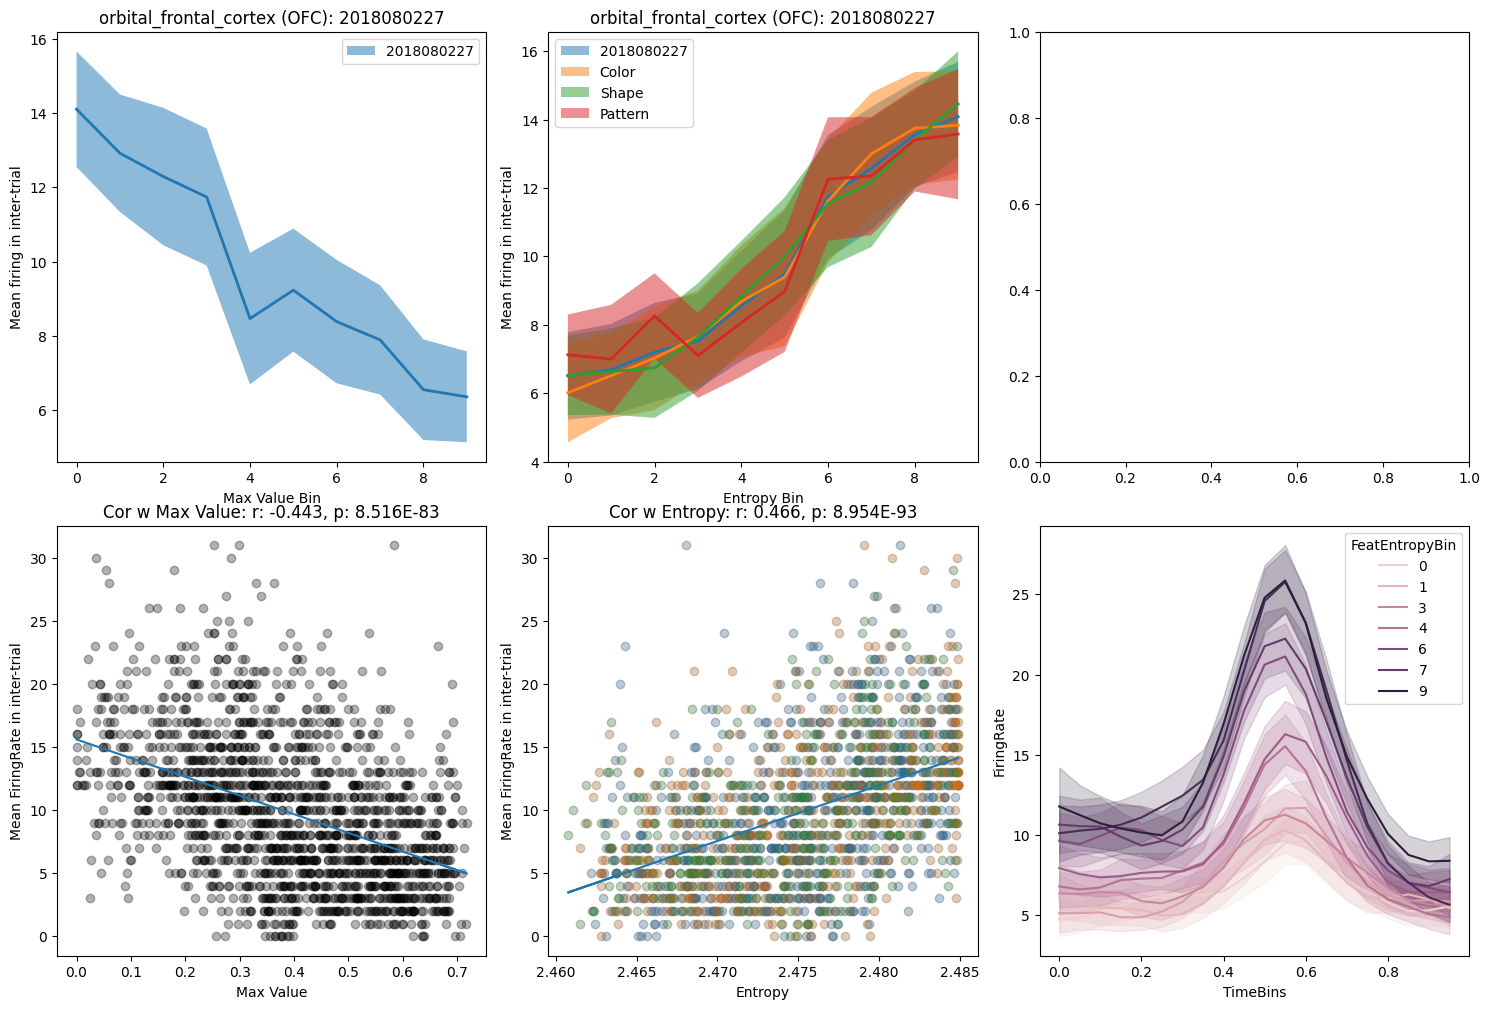

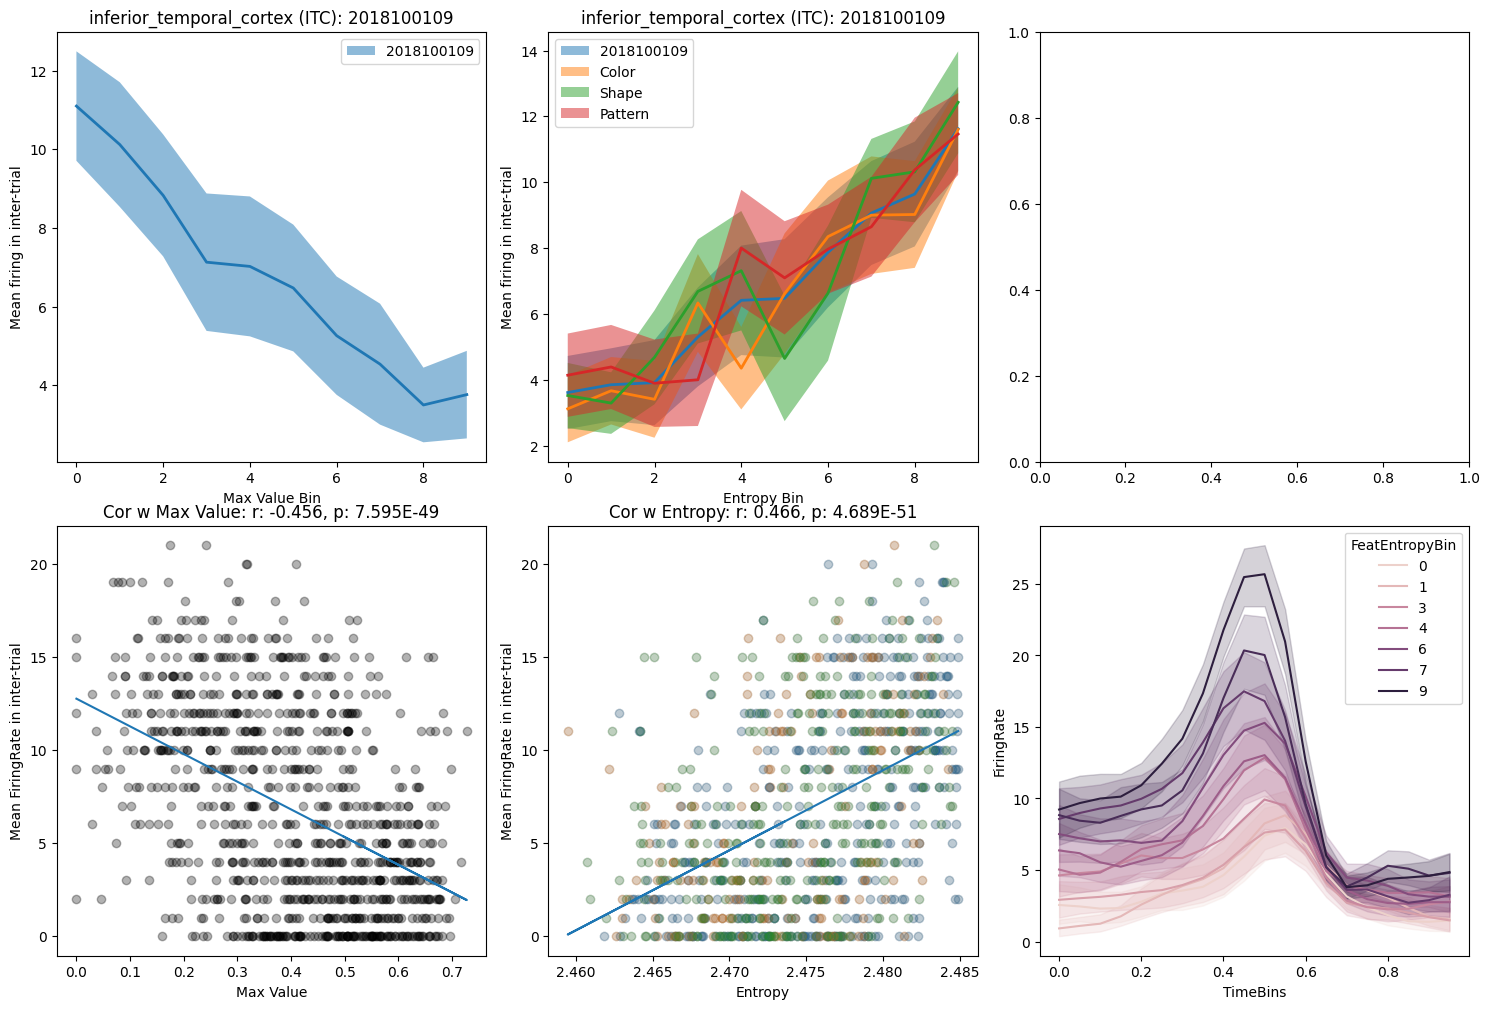

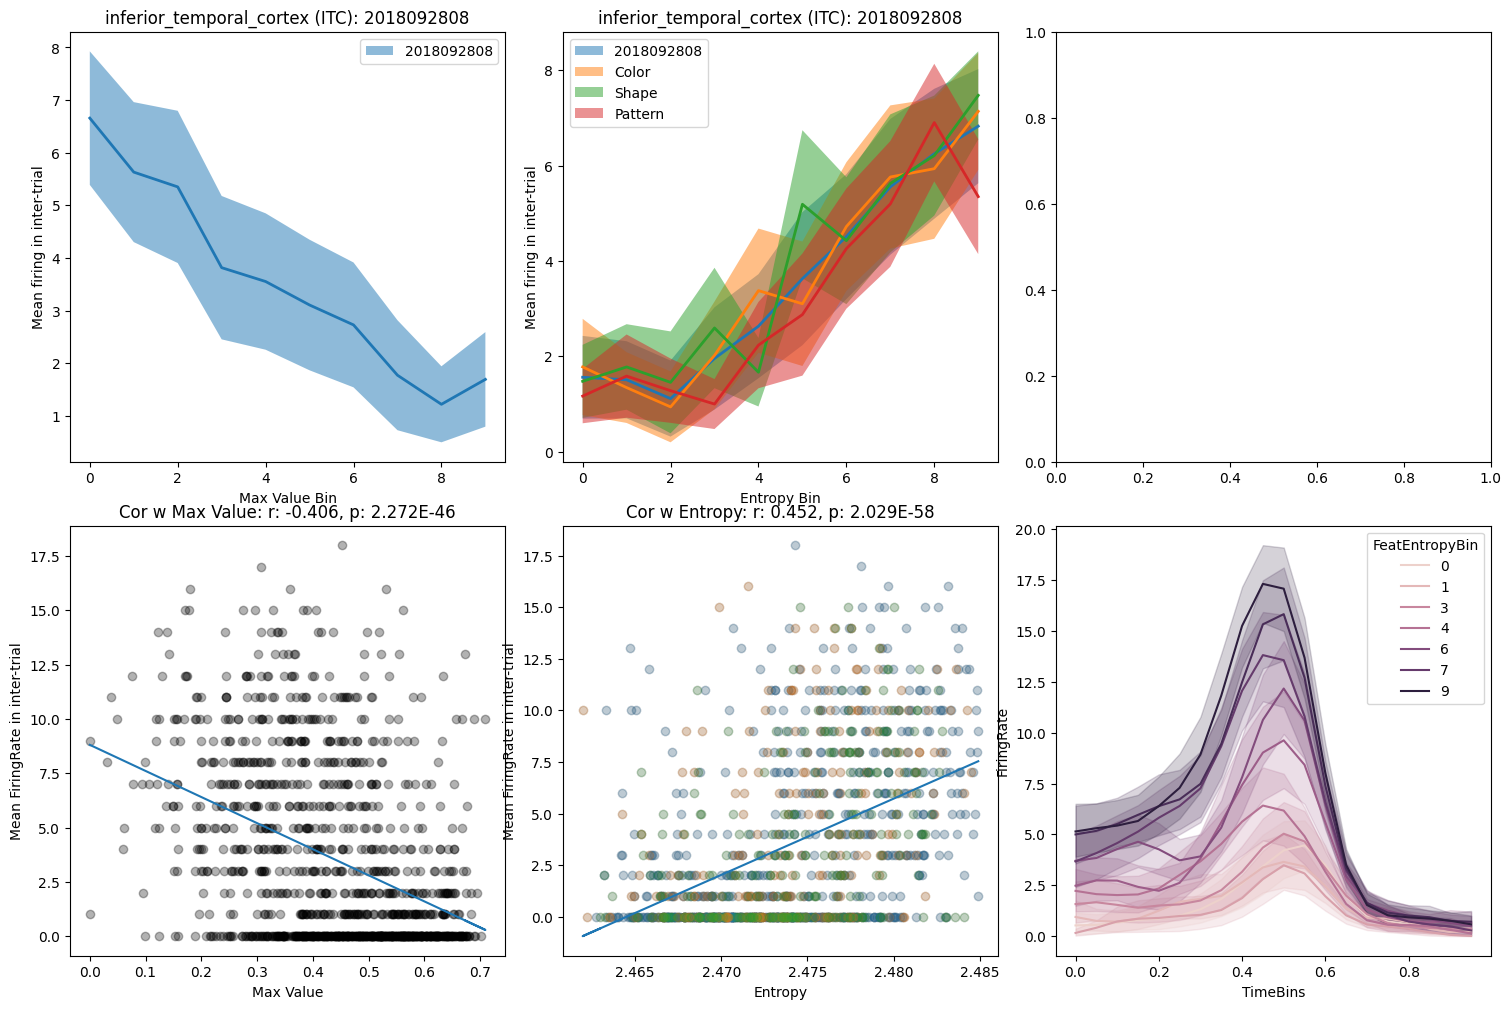

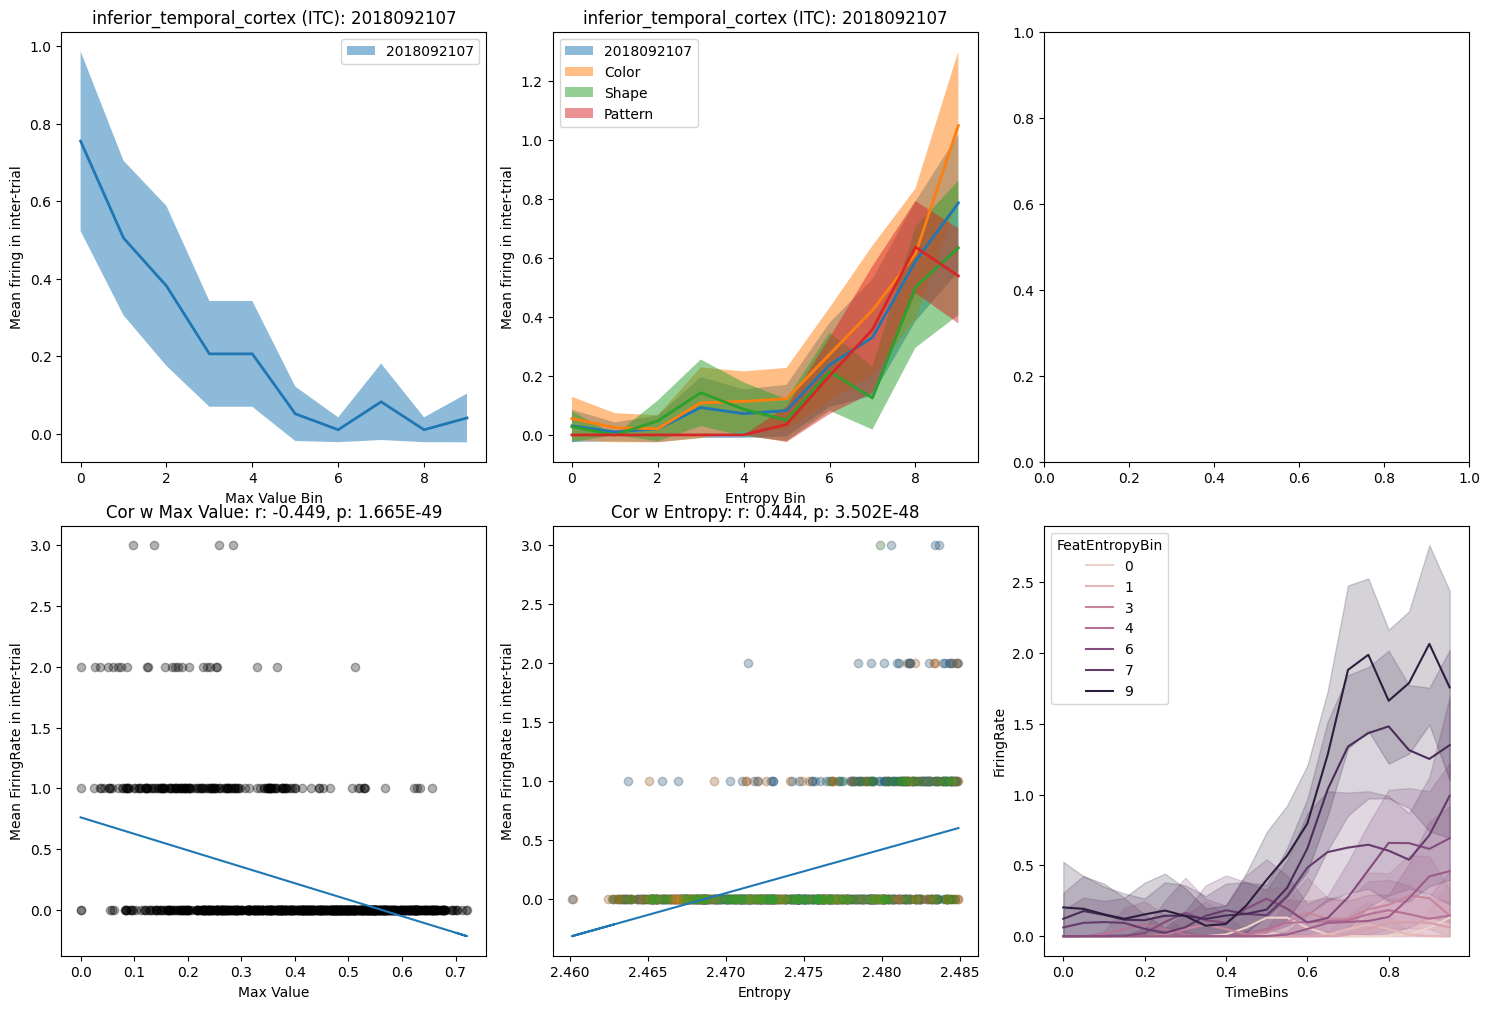

In [14]:
top = correlations.sort_values(by="r_mag", ascending=False)[:10]
# top_20 = merged[(merged.structure_level2 == "inferior_temporal_cortex (ITC)") & ()]
for i, row in top.iterrows():
    visualize_correlations(row, by_dims=True)